# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████| 4986/4986 [00:01<00:00, 2980.71it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9959201812744141), ('especially', 0.9954009652137756), ('wonderful', 0.9953501224517822), ('replacing', 0.995091438293457), ('quick', 0.9950376152992249), ('amazing', 0.9948198795318604), ('dirty', 0.9947546720504761), ('blueberry', 0.9946249127388), ('absolutely', 0.9944831132888794), ('supposed', 0.9944819211959839)]
[('liked', 0.9993910789489746), ('become', 0.9993536472320557), ('varieties', 0.999323308467865), ('world', 0.9992989301681519), ('beef', 0.9992901086807251), ('unlike', 0.9992457032203674), ('wow', 0.9992399215698242), ('style', 0.9992020726203918), ('type', 0.9992020130157471), ('choose', 0.9991804361343384)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████| 4986/4986 [00:04<00:00, 1231.89it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 4986/4986 [00:21<00:00, 230.49it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [35]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [36]:
df = filtered_data.iloc[:,lambda df:[9,6]].copy()
print(df.head(3))
print(df.shape)

                                                Text  Score
0  I have bought several of the Vitality canned d...      1
1  Product arrived labeled as Jumbo Salted Peanut...      0
2  This is a confection that has been around a fe...      1
(5000, 2)


In [37]:
X = np.array(df.iloc[:,0])
Y = np.array(df['Score'])
print(X.shape)
print(Y.shape)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data
print(X_train.shape)
print("======================")
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

(5000,)
(5000,)
(2244,) (2244,)
(1106,) (1106,)
(1650,) (1650,)
(2244,)
After vectorizations
(2244, 9200) (2244,)
(1106, 9200) (1106,)
(1650, 9200) (1650,)


# Applying K-NN using brute force

## Hyper perameter tunning using GridSearch

[1.         0.91543894 0.8629619  0.83427978 0.81156795 0.79626771
 0.78319719 0.77555884]
[0.5553237  0.61194545 0.652301   0.66406756 0.68114113 0.69794427
 0.70535196 0.71656024]
[0.01407646 0.02717321 0.03040501 0.02508494 0.02341542 0.01899959
 0.01548212 0.00121871]


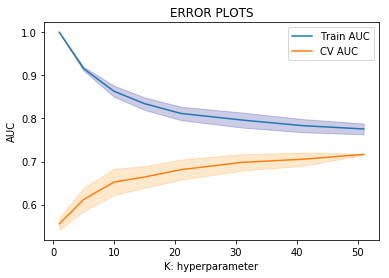

In [38]:
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_bow, y_train)
K = [1, 5, 10, 15, 21, 31, 41, 51]
train_auc= clf.cv_results_['mean_train_score']
print(train_auc)
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
print(cv_auc)
cv_auc_std= clf.cv_results_['std_test_score']
print(cv_auc_std)
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### The parameter  k is choosen, such a way that the distance between the Train AUC and Test AUC is minimum

## Testing

The optimal value of k =  15


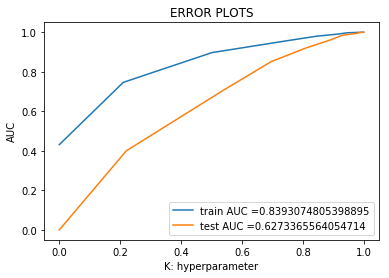

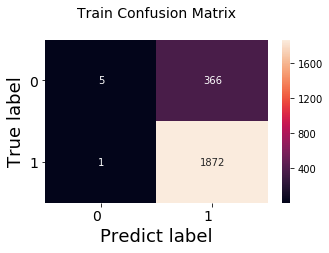

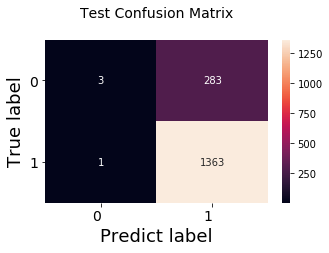

In [39]:
from sklearn.metrics import roc_curve, auc
q = 0
for i in range(len(cv_auc)):
    if(cv_auc[i]> cv_auc[q]):
        q = i
        opt_k = q*2 + 1  #Since i have taken odd k values from 1 to 100
print("The optimal value of k = ", opt_k)
best_k = opt_k
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_bow, y_train)
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)
"""""""""""""""""""""""""Another way of drawing confution matrix"""""""""""""""""""""""""""
"""from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))"""


'*******************************Confusion Matrix*****************************************'
cm = confusion_matrix(y_train,neigh.predict(X_train_bow))
tn, fp, fn, tp = cm.ravel()
   
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()


""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
cm = confusion_matrix(y_test,neigh.predict(X_test_bow))
tn, fp, fn, tp = cm.ravel()
   
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

   
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()

####  Observations

1) The optimal K value is 15 because if we consider K value as 51 there is a high chances of considering the outlier points

2) There is a significant difference in Train AUC and Test AUC, which means the designed model is simple.

3) From the confution matrix we can clearly state that The model is only predicting the Positive reviews better and all the
   negative reviews are missclassified, which means the model is not performing well

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [40]:
print(df.head(3))

                                                Text  Score
0  I have bought several of the Vitality canned d...      1
1  Product arrived labeled as Jumbo Salted Peanut...      0
2  This is a confection that has been around a fe...      1


In [41]:
X1 = np.array(df.iloc[:,0])
Y1 = np.array(df['Score'])
print(X1.shape)
print(Y1.shape)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("======================")
# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_idf = vectorizer.transform(X_train)
X_cv_tf_idf = vectorizer.transform(X_cv)
X_test_tf_idf = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tf_idf.shape, y_train.shape)
print(X_cv_tf_idf.shape, y_cv.shape)
print(X_test_tf_idf.shape, y_test.shape)
print("="*100)

(5000,)
(5000,)
(2244,) (2244,)
(1106,) (1106,)
(1650,) (1650,)
After vectorizations
(2244, 9200) (2244,)
(1106, 9200) (1106,)
(1650, 9200) (1650,)


## Hyper perameter tunning using GridSearch


[1.         0.90793571 0.8540738  0.82463071 0.80412855 0.78419256
 0.776598   0.77461694]
[0.53529979 0.5861901  0.6321692  0.64471484 0.65273729 0.65798506
 0.66545928 0.67559172]
[0.01767804 0.01758964 0.01603765 0.01960897 0.0206599  0.01658636
 0.0130932  0.00838028]


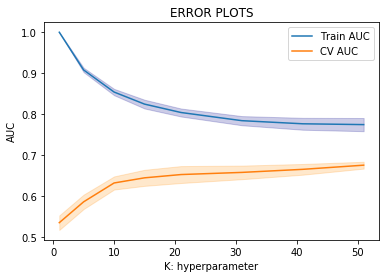

In [42]:
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_tf_idf, y_train)
K = [1, 5, 10, 15, 21, 31, 41, 51]
train_auc= clf.cv_results_['mean_train_score']
print(train_auc)
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
print(cv_auc)
cv_auc_std= clf.cv_results_['std_test_score']
print(cv_auc_std)
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

## Testing

The optimal value of k =  15
train_fpr (11,) train_tpr (11,) thresholds (9,)


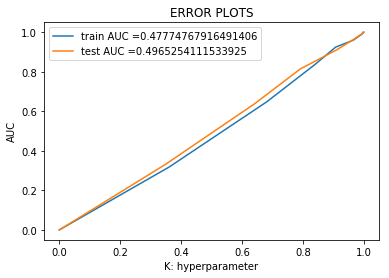

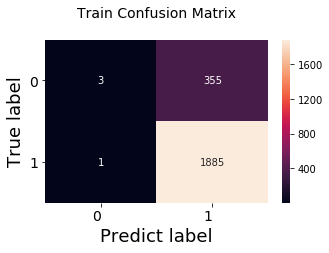

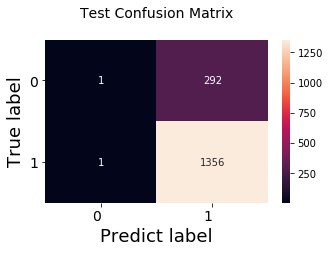

In [43]:
from sklearn.metrics import roc_curve, auc
q= 0
for i in range(len(cv_auc)):
    if(cv_auc[i]> cv_auc[q]):
        q = i
        opt_k = q*2 + 1  #Since i have taken odd k values from 1 to 100
print("The optimal value of k = ", opt_k)
best_k = opt_k
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_tf_idf, y_train)
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])
print("train_fpr",train_fpr.shape,"train_tpr",train_tpr.shape,"thresholds",thresholds.shape)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

"""""""""""""""""""""""""Another way of drawing confution matrix"""""""""""""""""""""""""""
"""from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))"""


'*******************************Confusion Matrix*****************************************'


cm = confusion_matrix(y_train,neigh.predict(X_train_tf_idf))
tn, fp, fn, tp = cm.ravel()
   
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()


""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
cm = confusion_matrix(y_test,neigh.predict(X_test_tf_idf))
tn, fp, fn, tp = cm.ravel()
   
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

   
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()



#### Observations

1) From the above AUC values, we can state that model is grtting underfit when applied for TFIDF.

2) From the confution matrix we can clearly state that The model is only predicting the Positive reviews better and all the negative reviews are missclassified, which means the model is not performing well.

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [44]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    

In [45]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [46]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3179
sample words  ['It', 'was', 'shipped', 'in', 'a', 'very', 'nice', 'package', 'and', 'I', 'have', 'no', 'complain', 'with', 'the', 'seller.', 'My', 'plant', 'growing', 'bigger', 'now', 'am', 'looking', 'for', 'pot', 'to', "It's", 'you', 'are', 'that', 'needs', 'minimal', 'this', 'is', 'might', 'What', 'lovely', 'tea', 'The', 'rose', 'mix,', 'when', 'brew', 'of', 'then', 'cup', 'your', 'sweet', 'scent', 'you!']


In [47]:
from tqdm import tqdm
import numpy as np

In [48]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|█████████████████████████████████████| 2244/2244 [00:03<00:00, 744.13it/s]


(2244, 50)
[-0.78122439 -0.72918634 -0.43928584 -0.45098309 -0.24920934 -0.15194456
  0.01586412 -1.09409086 -0.31365362  0.11575052 -0.01658111 -0.05485038
 -0.30325196  0.4364536  -0.23097348 -0.36966134  0.18249476  0.59543999
  0.01677876 -0.25006271 -0.39807956 -0.34859919 -0.35905412  0.62266469
  0.11259101  0.60600784 -0.08808187  0.32297016 -0.43641958 -0.16206123
  0.25993437 -1.05203956 -0.35705991  0.00749901  0.19510061  0.28015754
  0.01593418 -0.0822272  -0.3091982   0.4038409  -0.06598422  0.51269394
  0.06152539 -0.09195965  0.33104996  0.13205708 -0.09236972 -0.74605703
 -0.20268928 -0.10649917]


### Converting CV data text


In [49]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [50]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████| 1106/1106 [00:01<00:00, 715.77it/s]


(1106, 50)
[-0.85906294 -0.7774255  -0.47050612 -0.45685543 -0.25211954 -0.18938646
  0.02685173 -1.18345465 -0.34665486  0.11536932 -0.0027797  -0.05695735
 -0.3071727   0.48529735 -0.26008503 -0.397308    0.21659885  0.66112462
 -0.00140048 -0.30625706 -0.45153364 -0.35657301 -0.38000302  0.68634725
  0.10599946  0.67928347 -0.07886364  0.34086589 -0.4946796  -0.16193654
  0.27443489 -1.18363783 -0.42730623 -0.02370729  0.21423635  0.30914395
  0.05370743 -0.09669559 -0.33200867  0.41739723 -0.05888219  0.55864336
  0.07883541 -0.12154982  0.33971733  0.14180718 -0.0742107  -0.78839373
 -0.2123179  -0.10909629]


### Converting Test data text

In [51]:
i= 0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [52]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████| 1650/1650 [00:02<00:00, 754.72it/s]


(1650, 50)
[-0.82191892 -0.77749654 -0.47899412 -0.47696718 -0.2479697  -0.16768339
  0.01043244 -1.17974619 -0.33018957  0.12648932 -0.01401918 -0.05487262
 -0.30947906  0.46190366 -0.259868   -0.39812504  0.20218966  0.64516835
  0.02405045 -0.27897027 -0.435153   -0.36150969 -0.38146145  0.64010256
  0.11071835  0.63948983 -0.07796038  0.3627949  -0.44731524 -0.179642
  0.2668705  -1.09842775 -0.37343733 -0.00265489  0.19993659  0.3012052
  0.02567591 -0.09835389 -0.33689196  0.42653737 -0.05830911  0.5474004
  0.05914556 -0.09532176  0.32843008  0.12430553 -0.08888625 -0.80139205
 -0.21476462 -0.09342364]


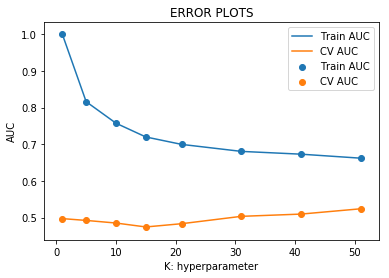

In [53]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

The optimal value of k =  15


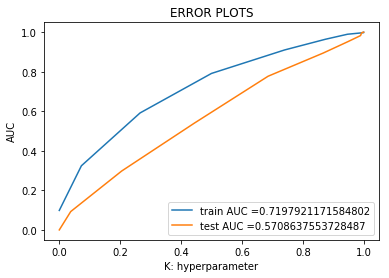

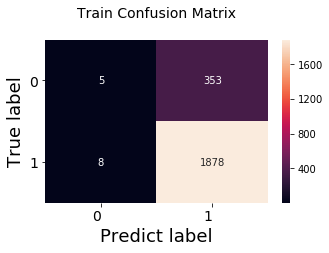

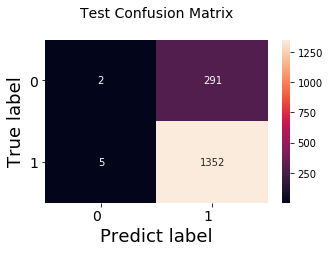

In [54]:
q=0
for i in range(len(cv_auc)):
    if(cv_auc[i]> cv_auc[q]):
        q = i
        opt_k = q*2 + 1  #Since i have taken odd k values from 1 to 100
print("The optimal value of k = ", opt_k)


neigh = KNeighborsClassifier(n_neighbors= opt_k, algorithm = 'brute')
neigh.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

"""from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))
"""
cm = confusion_matrix(y_train,neigh.predict(sent_vectors_train))
tn, fp, fn, tp = cm.ravel()
   
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()


""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
cm = confusion_matrix(y_test,neigh.predict(sent_vectors_test))
tn, fp, fn, tp = cm.ravel()
   
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

   
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()





#### K-NN Avg W2v has the similar drawbacks like Bag of words

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [57]:
tfidf_feat = model.get_feature_names()
tfidf_sent_vectors = [];
i = 0;
list_of_sentence = []
for sentance in X_train:
    list_of_sentance.append(sentance.split())
    
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 2244/2244 [00:16<00:00, 134.55it/s]


In [58]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(2244, 50)
[-0.46742818 -0.45133389 -0.27842732 -0.28314206 -0.15795304 -0.09241698
  0.01544286 -0.68461604 -0.19162976  0.07806156 -0.00863238 -0.04220436
 -0.20286776  0.26578296 -0.14018907 -0.22139046  0.09992741  0.36298521
  0.016239   -0.14717471 -0.24642583 -0.22737006 -0.22855374  0.38782502
  0.08053005  0.35410862 -0.06227198  0.18991184 -0.27022876 -0.09553071
  0.16681223 -0.6399842  -0.2173636   0.00847966  0.11954825  0.17265126
  0.00236452 -0.05403192 -0.18599153  0.2536283  -0.04410477  0.3096759
  0.02862462 -0.05018376  0.20786803  0.08110592 -0.05752221 -0.46367273
 -0.12727067 -0.0701626 ]


### Converting CV data text

In [59]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [60]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
tfidf_cv_sent_vectors_cv = np.array(sent_vectors_cv)
print(tfidf_cv_sent_vectors_cv[0])

100%|█████████████████████████████████████| 1106/1106 [00:01<00:00, 741.93it/s]


[-0.85906294 -0.7774255  -0.47050612 -0.45685543 -0.25211954 -0.18938646
  0.02685173 -1.18345465 -0.34665486  0.11536932 -0.0027797  -0.05695735
 -0.3071727   0.48529735 -0.26008503 -0.397308    0.21659885  0.66112462
 -0.00140048 -0.30625706 -0.45153364 -0.35657301 -0.38000302  0.68634725
  0.10599946  0.67928347 -0.07886364  0.34086589 -0.4946796  -0.16193654
  0.27443489 -1.18363783 -0.42730623 -0.02370729  0.21423635  0.30914395
  0.05370743 -0.09669559 -0.33200867  0.41739723 -0.05888219  0.55864336
  0.07883541 -0.12154982  0.33971733  0.14180718 -0.0742107  -0.78839373
 -0.2123179  -0.10909629]


In [61]:
tfidf_cv_sent_vectors_cv = np.array(tfidf_cv_sent_vectors_cv)
print(tfidf_cv_sent_vectors_cv.shape)

(1106, 50)


### Converting Test data text

In [62]:
i= 0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [63]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
tfidf_test_sent_vectors_test = np.array(sent_vectors_test)
print(tfidf_test_sent_vectors_test[0])

100%|█████████████████████████████████████| 1650/1650 [00:02<00:00, 767.23it/s]


[-0.82191892 -0.77749654 -0.47899412 -0.47696718 -0.2479697  -0.16768339
  0.01043244 -1.17974619 -0.33018957  0.12648932 -0.01401918 -0.05487262
 -0.30947906  0.46190366 -0.259868   -0.39812504  0.20218966  0.64516835
  0.02405045 -0.27897027 -0.435153   -0.36150969 -0.38146145  0.64010256
  0.11071835  0.63948983 -0.07796038  0.3627949  -0.44731524 -0.179642
  0.2668705  -1.09842775 -0.37343733 -0.00265489  0.19993659  0.3012052
  0.02567591 -0.09835389 -0.33689196  0.42653737 -0.05830911  0.5474004
  0.05914556 -0.09532176  0.32843008  0.12430553 -0.08888625 -0.80139205
 -0.21476462 -0.09342364]


In [64]:
tfidf_test_sent_vectors_test = np.array(tfidf_test_sent_vectors_test)
print(tfidf_test_sent_vectors_test.shape)

(1650, 50)


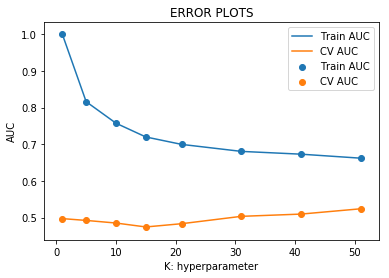

In [65]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []


K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

The optimal value of k =  15


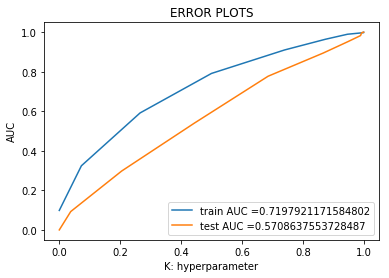

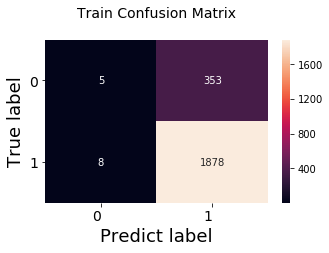

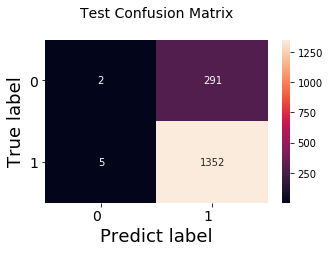

In [66]:
q =0
for i in range(len(cv_auc)):
    if(cv_auc[i]> cv_auc[q]):
        q = i
        opt_k = q*2 + 1  #Since i have taken odd k values from 1 to 100
print("The optimal value of k = ", opt_k)

neigh = KNeighborsClassifier(n_neighbors= opt_k, algorithm = 'brute')
neigh.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

""""from sklearn.metrics import confusion_matrix
    print("Train confusion matrix")
    print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))"""



cm = confusion_matrix(y_train,neigh.predict(sent_vectors_train))
tn, fp, fn, tp = cm.ravel()
   
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()


""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
cm = confusion_matrix(y_test,neigh.predict(sent_vectors_test))
tn, fp, fn, tp = cm.ravel()
   
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

   
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()



#### K-NN TFIDF W2v has the similar drawbacks like Bag of words

In [67]:
# Please write all the code with proper documentation

## [5.2] Applying KNN kd-tree

Kd_tree is a algoritham, which has better computational performance in term's of time than the brute force algoritham

Time complexity of KD-tree(approximately)

Best case = O(log(n))

worst case = O(n)

where n is the No of points

In [68]:
X_1 = np.array(df.iloc[:,0])
y_1 = np.array(df['Score'])
print(X1.shape)
print(Y1.shape)


(5000,)
(5000,)


#### splitting Data

In [69]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
print('The shape of train is',X_train.shape, y_train.shape)
print('The shape of CV is',X_cv.shape, y_cv.shape)
print('The shape of test is',X_test.shape, y_test.shape)

The shape of train is (2244,) (2244,)
The shape of CV is (1106,) (1106,)
The shape of test is (1650,) (1650,)


#### checking how many positive and negative reviews, Train, Cv and Test data has

In [70]:
unique_train,counts_train = np.unique(y_train, return_counts= True)
unique_cv,counts_cv = np.unique(y_cv, return_counts= True)
unique_test,counts_test = np.unique(y_test, return_counts= True)
print('Train',np.asarray((unique_train,counts_train)).T)
print('cv',np.asarray((unique_cv,counts_cv)).T)
print('Test',np.asarray((unique_test,counts_test)).T)

Train [[   0  363]
 [   1 1881]]
cv [[  0 198]
 [  1 908]]
Test [[   0  252]
 [   1 1398]]


#### Defining K-NN

In [71]:
def knn(X_train_vec, X_test_vec, X_cv_vec, Y_cv, Y_test, Y_train, algo):
    X_train_amazon = X_train_vec
    X_cv_amazon = X_cv_vec
    X_test_amazon = X_test_vec
    print("After vectorizations")
    #print(X_train_amazon.shape, Y_train.shape)
    #print(X_cv_amazon.shape, Y_cv.shape)
    #print(X_test_amazon.shape, y_test.shape)
    print("="*100)
    
    #tunning using GridSearch#
    from sklearn.model_selection import GridSearchCV
    neigh = KNeighborsClassifier(algorithm= algo)
    parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
    clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
    clf.fit(X_train_amazon,Y_train)
    K = [1, 5, 10, 15, 21, 31, 41, 51]
    train_auc= clf.cv_results_['mean_train_score']
    print(train_auc)
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    print(cv_auc)
    cv_auc_std= clf.cv_results_['std_test_score']
    print(cv_auc_std)
    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
       
    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
        
    from sklearn.metrics import roc_curve, auc
    q = 0
    for i in range(len(cv_auc)):
        if(cv_auc[i]> cv_auc[q]):
            q = i
            opt_k = q*2 + 1  #Since i have taken odd k values from 1 to 100
    print("The optimal value of k = ", opt_k)
    best_k = opt_k
    neigh = KNeighborsClassifier(n_neighbors=best_k)
    neigh.fit(X_train_amazon, y_train)
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
    train_fpr, train_tpr, thresholds = roc_curve(Y_train, neigh.predict_proba(X_train_amazon)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(Y_test, neigh.predict_proba(X_test_amazon)[:,1])
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    print("="*100)
    cm = confusion_matrix(y_train,neigh.predict(X_train_amazon))
    tn, fp, fn, tp = cm.ravel()
   
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Train Confusion Matrix\n",size=14)
    plt.show()
    
    cm = confusion_matrix(Y_test,neigh.predict(X_test_amazon))
    tn, fp, fn, tp = cm.ravel()
   
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Test Confusion Matrix\n",size=14)
    plt.show()

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [72]:
# Please write all the code with proper documentation
count_vect = CountVectorizer(min_df=10,max_features=500)
bow_train_vec = count_vect.fit_transform(X_train.ravel())
bow_test_vec = count_vect.transform(X_test)
bow_cv_vec = count_vect.transform(X_cv)
print("The number of unique words :",bow_train_vec.get_shape()[1])

The number of unique words : 500


After vectorizations
[1.         0.86449313 0.8279533  0.79983941 0.78076986 0.76822982
 0.76639382 0.76648938]
[0.53832584 0.61480398 0.645665   0.64772782 0.65336488 0.67290566
 0.69164679 0.69653692]
[0.00629063 0.00518556 0.00917799 0.00942856 0.01376486 0.02865241
 0.02508804 0.0270692 ]


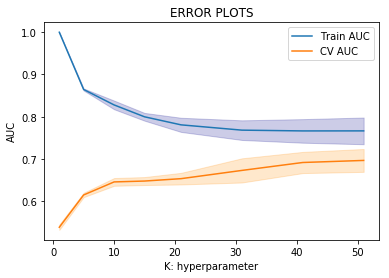

The optimal value of k =  15


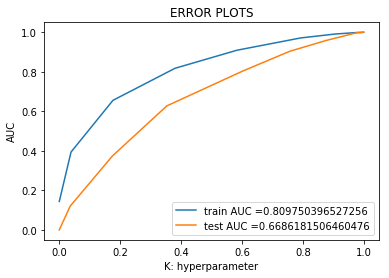

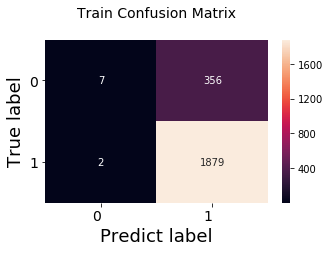

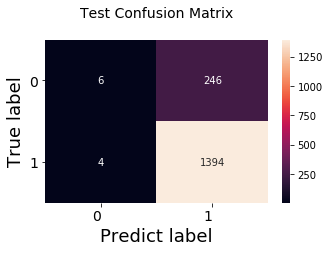

In [73]:
knn(bow_train_vec.toarray(),bow_test_vec.toarray(),bow_cv_vec.toarray(),y_cv,y_test, y_train,'kd_tree')

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [74]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)
train_tf_idf = tf_idf_vect.fit_transform(X_train)
test_tf_idf = count_vect.transform(X_test)
cv_tf_idf = count_vect.transform(X_cv)
print("The number of unique words :",train_tf_idf.get_shape()[1])


The number of unique words : 500


After vectorizations
[1.         0.87757358 0.84074707 0.82994528 0.82479207 0.80991022
 0.80547043 0.80924128]
[0.59059494 0.63102315 0.65998392 0.68103611 0.70973765 0.72303725
 0.74315139 0.74386975]
[0.02599636 0.02716284 0.00603355 0.00448507 0.01404627 0.02550608
 0.02835361 0.03085638]


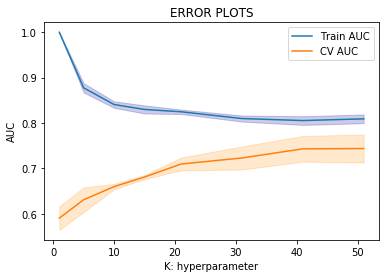

The optimal value of k =  15


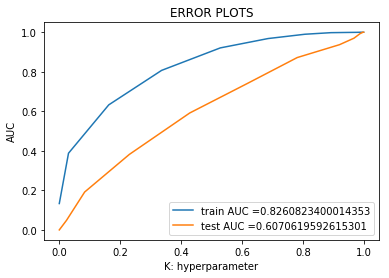

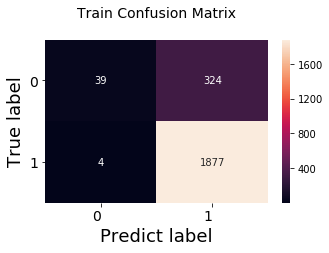

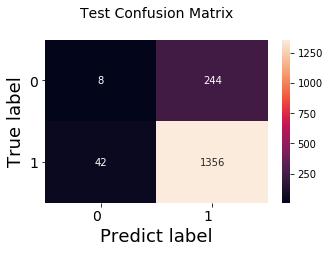

In [75]:
knn(train_tf_idf.toarray(),test_tf_idf.toarray(),cv_tf_idf.toarray(),y_cv,y_test, y_train,'kd_tree')

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

After vectorizations
[0.99986709 0.81877386 0.72903788 0.68794348 0.64955229 0.62276198
 0.613264   0.59859469]
[0.50495384 0.50985057 0.50123681 0.4984051  0.49329968 0.49476936
 0.49546136 0.49888182]
[0.00886566 0.0154123  0.00724553 0.01125709 0.01215454 0.02311553
 0.01342201 0.00624399]


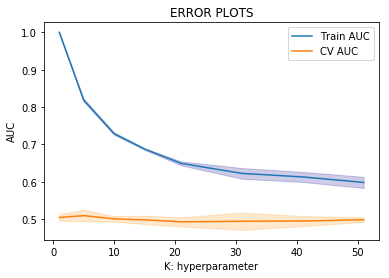

The optimal value of k =  3


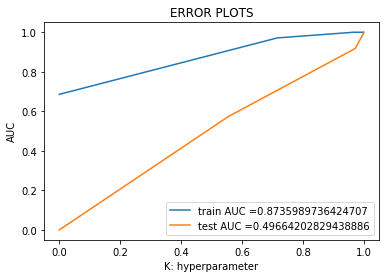

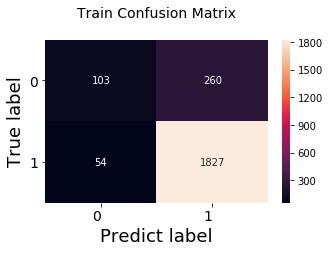

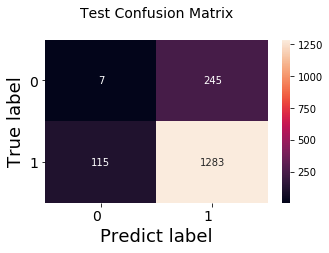

In [76]:
# Please write all the code with proper documentation
knn(sent_vectors_train,sent_vectors_test,sent_vectors_cv,y_cv,y_test, y_train,'kd_tree')


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

After vectorizations
[0.99784931 0.81245524 0.73502588 0.69982283 0.66668479 0.63411463
 0.61643457 0.60301031]
[0.50183655 0.49873682 0.51716161 0.50766034 0.5091366  0.49290645
 0.4867795  0.47670045]
[0.00948652 0.01204365 0.0160778  0.02258153 0.01707106 0.00722735
 0.00693057 0.00564924]


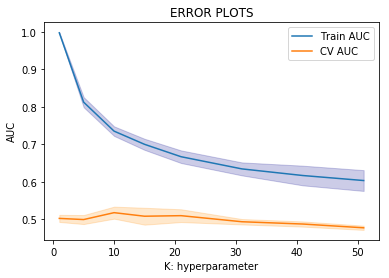

The optimal value of k =  5


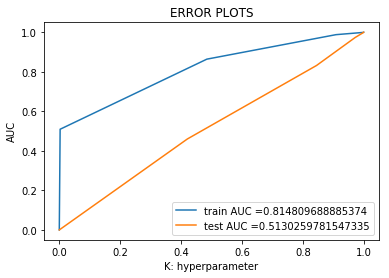

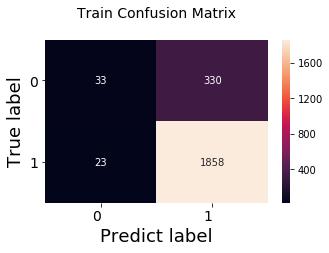

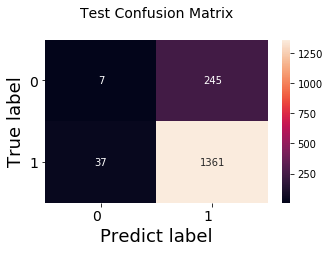

In [77]:
# Please write all the code with proper documentation
knn(tfidf_sent_vectors,tfidf_test_sent_vectors_test,tfidf_cv_sent_vectors_cv,y_cv,y_test,y_train,'kd_tree')


# [6] Conclusions

In [9]:
# Please compare all your models using Prettytable library
#https://ptable.readthedocs.io/en/latest/tutorial.html
from prettytable import from_csv
fp = open("final.csv", "r")
mytable = from_csv(fp)
print(mytable)

+---------------+---------+-----------------+----------+
| ï»¿Vectorizer |  Model  | Hyper Parameter | Test AUC |
+---------------+---------+-----------------+----------+
|      BOW      |  Brute  |        15       |   0.62   |
|     TFIDF     |  Brute  |        15       |   0.49   |
|    AVG W2V    |  Brute  |        15       |   0.57   |
|   TFIDF W2V   |  Brute  |        15       |   0.57   |
|      BOW      | KD-Tree |        15       |   0.66   |
|     TFIDF     | KD-Tree |        15       |   0.6    |
|    AVG W2V    | KD-Tree |        3        |   0.49   |
|   TFIDF W2V   | KD-Tree |        5        |   0.51   |
+---------------+---------+-----------------+----------+


1) From the above results we can say that K-NN is not a better model for the Dataset

2) There is not much difference in the Brute force Auc and KD-tree AUC

3) In this model almost all the negative reviews are misclassified